In [2]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import h5py
import os

from scipy import signal
from scipy import io

import librosa

In [3]:
import models.models_mae as models_mae

In [62]:
%load_ext autoreload
%autoreload 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def read_all_seqs(dir='../data', files=None):
    if files is None:
        files = map(lambda filename: dir + '/' + filename, os.listdir(dir))

    seqs = []
    for filename in files:
        with h5py.File(filename, 'r') as f:
            seqs.extend([f[h5py.h5r.get_name(elem, f.id)][:] for elem in f['chirp_sequence_array']])

    return seqs

In [5]:
def get_sample(use_wav_example=False, seq_idx=200, mic_idx=0, hopsize=320, upsample_rate=4, scale=1):
    if use_wav_example:
        _, Y = io.wavfile.read('./audioset/Y__p-iA312kg.wav')
        return Y
    seqs = read_all_seqs()
    X = seqs[seq_idx].T[:, 0:4] * scale

    x = signal.resample(X[:, mic_idx], X.shape[0] * upsample_rate)
    x = x * signal.windows.tukey(len(x))
    x = np.hstack((x, np.zeros(320319 // 320 * hopsize - len(x))))

    return x

In [6]:
def mel_spectrogram(x, model):
    old_shape = x.size()
    x = x.reshape(-1, old_shape[2])
    x = model.mel(x)
    x = (x - model.frame_mean[None, :, None]) / model.frame_std[None, :, None]
    x = x.reshape(old_shape[0], old_shape[1], x.shape[1], x.shape[2])
    return x

In [7]:
def test_model_forward(x, model, device, mask_ratio=0.75):
    model = model.to(device)

    x = torch.from_numpy(x.reshape(1, 1, -1).astype('float32'))
    x = x.to(device)
    x = x.type(torch.FloatTensor).cuda()

    mel_x = mel_spectrogram(x, model)
    mel_x = mel_x[:, :, :model.patch_embed.img_size[0], :model.patch_embed.img_size[1]]

    loss, pred, mask = model.forward(x, mask_ratio)
    x_prime = model.unpatchify(pred[:, :, :, np.newaxis])
    
    return mel_x, x_prime, loss, mask


In [8]:
def plot_specgram(Sx):
    plt.figure(figsize=(15, 4))
    plt.imshow(np.flip(Sx, axis=0), aspect='auto')
    plt.colorbar()
    plt.show()

In [9]:
def mask_to_patched_mask(mask, model):
    patchified_mask = model.patchify(torch.from_numpy(1 - mask[np.newaxis, np.newaxis, :, :]))[0, :, :, 0]
    return ~(torch.sum(patchified_mask, axis=1) > 0)

In [164]:
def test_imputation(x, model, device, mask):
    model = model.to(device)

    patch_mask = mask_to_patched_mask(mask, model).reshape(1, -1).type(torch.FloatTensor).to(device)
    mask = torch.from_numpy(mask.astype('float32')).to(device)

    x = torch.from_numpy(x.reshape(1, 1, -1).astype('float32'))
    x = x.to(device)
    x = x.type(torch.FloatTensor).cuda()

    mel_x = mel_spectrogram(x, model)
    mel_x = mel_x[:, :, :model.patch_embed.img_size[0], :model.patch_embed.img_size[1]]
    mel_x_masked = mel_x * mask - 50*(1-mask) # this is just to test that the masking is correct
    latent = model.patch_embed(mel_x_masked)
    latent = latent + model.pos_embed[:, 1:, :]

    D = latent.shape[2]

    ids_keep = torch.nonzero(patch_mask, as_tuple=True)[1]
    ids_mask = torch.nonzero(1 - patch_mask, as_tuple=True)[1]
    ids_restore = torch.argsort(torch.cat((ids_keep, ids_mask))).reshape(1, -1)
    
    latent = torch.gather(latent, dim=1, index=ids_keep.reshape(1, -1).unsqueeze(-1).repeat(1, 1, D))

    cls_token = model.cls_token + model.pos_embed[:, :1, :]
    cls_tokens = cls_token.expand(latent.shape[0], -1, -1)
    latent = torch.cat((cls_tokens, latent), dim=1)

    # apply Transformer blocks
    for blk in model.blocks:
        latent = blk(latent)
    latent = model.norm(latent)

    pred = model.forward_decoder(latent, ids_restore)
    x_prime = model.unpatchify(pred[:, :, :, np.newaxis])

    loss = model.forward_loss(mel_x, pred, patch_mask)

    # test = np.zeros((1, ids_restore.shape[1], 16*16, 1))
    # test[:, ids_mask.detach().cpu().numpy(), :, :] = 1
    # test = model.unpatchify(torch.from_numpy(test).to(device))

    return mel_x, x_prime, loss#, test.detach().cpu().numpy()
    

In [11]:
## Setup pytorch

GPU_NUM = '0'

device = torch.device(('cuda:' + GPU_NUM) if (torch.cuda.is_available() and GPU_NUM != '-1') else 'cpu')
print("Using device: {}".format(device))
if device == 'cuda':
    print("Device index: {}".format(torch.cuda.current_device()))


Using device: cuda:0


In [12]:
STATE = 'checkpoint-399.pth'
model = models_mae.__dict__['mae_vit_base_patch16'](
    norm_pix_loss=False,
    norm_file='./audioset/mean_std_128.npy',
    hopsize=15
)
checkpoint = torch.load(STATE, map_location='cpu')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

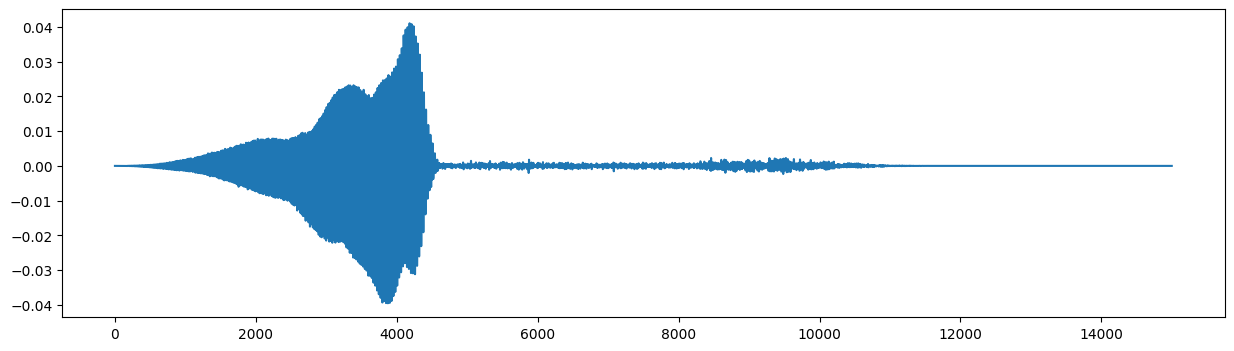

In [145]:
x = get_sample(hopsize=15, seq_idx=20, upsample_rate=100//30, mic_idx=2, scale=0.1)
plt.figure(figsize=(15, 4))
plt.plot(x)

In [146]:
mel_x, x_prime, loss, mask = test_model_forward(x, model, device, 0.4)

tensor([[-0.0000e+00, -1.1438e-11, -3.5759e-10,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')
tensor([[-0.0000e+00, -1.1438e-11, -3.5759e-10,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')


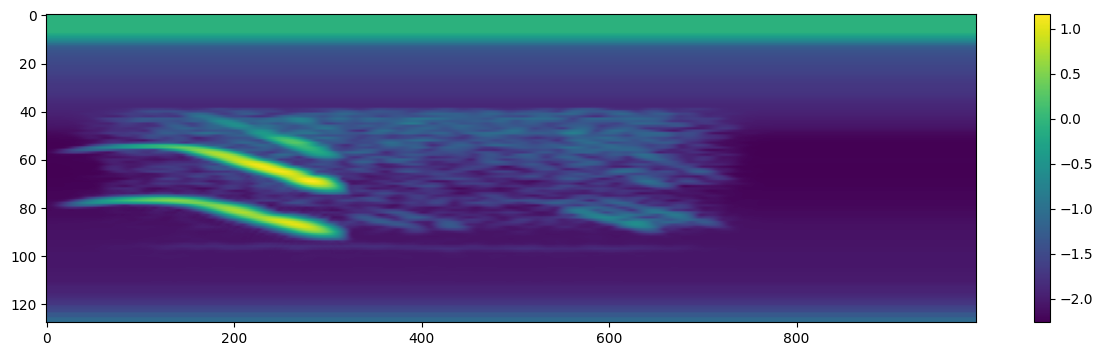

In [147]:
mel_x = mel_x[0][0].detach().cpu().numpy()
plot_specgram(mel_x)

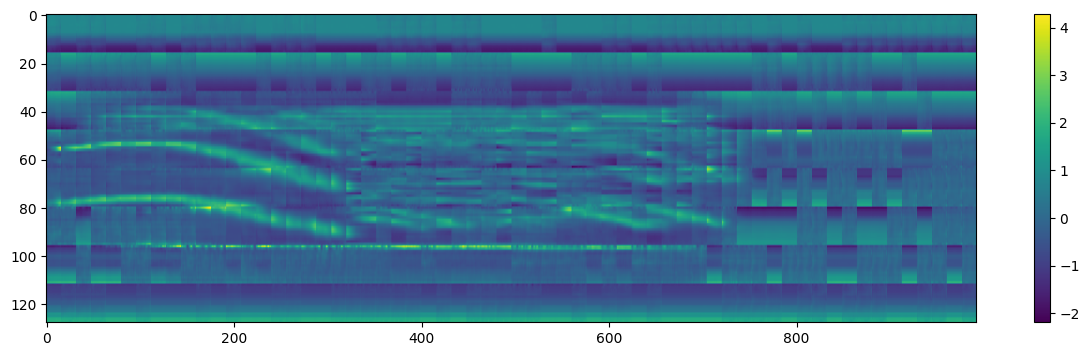

In [148]:
x_prime = x_prime[0][0].detach().cpu().numpy()
plot_specgram(x_prime)

In [179]:
mask = np.ones(mel_x.shape)
mask[32:80, 200:250] = 0
# mask[40:80, 200:250] = 0
# mask[50:80, 550:600] = 0

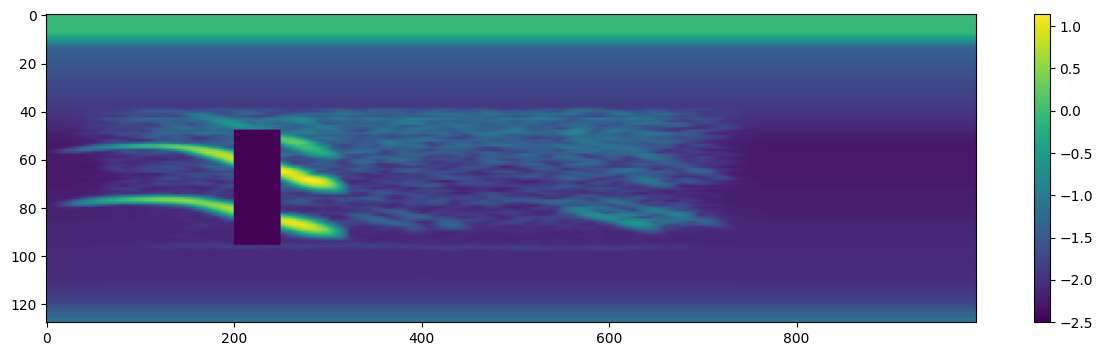

In [180]:
masked_mel = mel_x * mask - 2.5*(1-mask)
plot_specgram(masked_mel)

In [181]:
# semimasked_x = librosa.feature.inverse.mel_to_audio(semimasked_mel_x, sr=32_000, n_fft=1024, hop_length=10)
# plt.figure(figsize=(15, 3))
# plt.plot(semimasked_x)

tensor([[-0.0000e+00, -1.1438e-11, -3.5759e-10,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], device='cuda:0')


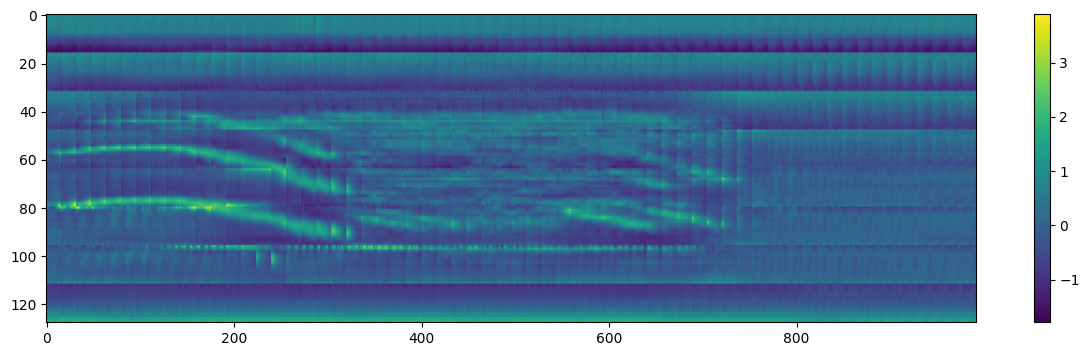

In [186]:
mel_x, x_prime, loss = test_imputation(x, model, device, mask)
mel_x = mel_x.detach().cpu().numpy()[0][0]
x_prime = x_prime[0][0].detach().cpu().numpy()
plot_specgram(x_prime)

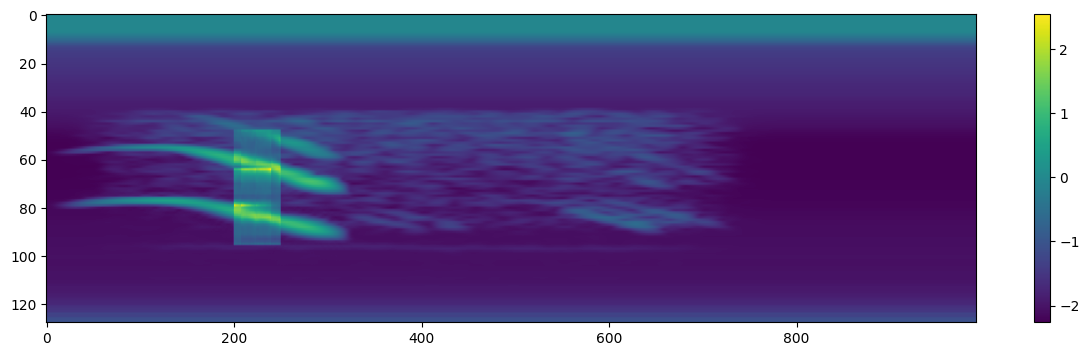

In [187]:
reconst_mel_x = mel_x * mask + x_prime * (1-mask)
plot_specgram(reconst_mel_x)